# Imports and Other Setup

## Imports

In [ ]:
from collections import Counter
from google.colab import files
import math
import nltk
import matplotlib.pyplot as plt
import re
import requests
import wordcloud

## Setup Stop Words and Lemmatizer

In [ ]:
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Lexicon

When you run the code below, you will be prompted to upload a file from your computer. Upload the the file [lexicon.txt](https://seneca-my.sharepoint.com/:t:/g/personal/william_dick_senecacollege_ca/ERgdE83xJjVGrWZj6xkCJTQB6egoqC5v6UPnzvNl0bBhWw?e=KwIFUw) (you'll need to save it to your computer first). 

This file is a lexicon. It contains a list of tokens and an associated polarity score. A positive score means the word has positive sentiment. A negative score means the word has negative sentiment. A score of zero means the word is neutral. 

After uploading the lexicon as a flat file, we store it in a Python dictionary called `lexicon`. 

In [ ]:
uploaded_files = files.upload()
lexicon_file = uploaded_files['lexicon.txt'].decode()
lexicon = {}
for line in lexicon_file.split('\n'):
  split_line = line.split('\t')
  token = split_line[0]
  score = float(split_line[1])
  lexicon[token] = score

Saving lexicon.txt to lexicon (3).txt


In [ ]:
# example
example_words = ['great','horrible','bad','hello']
for word in example_words:
  if word in lexicon:
    print("'"+word+"': "+str(lexicon[word]))
  else:
    print("'"+word+"': not in lexicon")

'great': 3.1
'horrible': -2.5
'bad': -2.5
'hello': not in lexicon


In [ ]:
# example
word = 'horrible'
lexicon[word]

-2.5

# Sentiment Score Functions

## `getSentimentScore(doc)`

`getSentimentScore(doc)` takes a document (a string) and returns a polarity score. The score is equal to `sum_of_scores / math.sqrt((sum_of_scores * sum_of_scores) + 15)`, where `sum_of_scores` of equal to the sum of the polarity scores of each token in the document. This method of scoring comes from VADER. 

In [ ]:
def getSentimentScore(doc):
  sum_of_scores = 0
  tokens = tokenize(doc)
  for token in tokens:
    if token in lexicon:
      score = lexicon[token]
    else:
      score = 0
    sum_of_scores += score
  norm_score = sum_of_scores / math.sqrt((sum_of_scores * sum_of_scores) + 15)
  return(norm_score)

## `getCorpusSentimentScore(corpus)`

`getCorpusSentimentScore(corpus)` takes a corpus (a list of strings) and returns a polarity score. The score is equal to `sum_of_scores / math.sqrt((sum_of_scores * sum_of_scores) + 15)`, where `sum_of_scores` of equal to the sum of the polarity scores of each token in the corpus. 

In [ ]:
def getCorpusSentimentScore(corpus):
  sum_of_scores = 0
  for doc in corpus:
    tokens = tokenize(doc)
    for token in tokens:
      if token in lexicon:
        score = lexicon[token]
      else:
        score = 0
      sum_of_scores += score
  norm_score = sum_of_scores / math.sqrt((sum_of_scores * sum_of_scores) + 15)
  return(norm_score)

## `getCorpusSentimentCounts(corpus)`


`getCorpusSentimentCounts(corpus)` takes a corpus (a list of strings) and returns a Python dictionary containing four keys: 
* `'pos'` for the number of positive documents in the corpus, 
* `'neg'` for the number of negative documents in the corpus, 
* `'neu'` for the number of negative documents in the corpus, and 
* `'tot'` for the total number of documents in the corpus. 

The sentiment of a document is determined by `getSentimentScore(doc)`:
* positive if 0.05 or above
* negative if -0.05 or below
* neutral otherwise



In [ ]:
def getCorpusSentimentCounts(corpus):
  counts = {'pos':0,'neg':0,'neu':0,'tot':0}
  for doc in corpus:
    score = getSentimentScore(doc)
    if score>=0.05:
      counts['pos'] += 1
    elif score<=-0.05:
      counts['neg'] += 1
    else:
      counts['neu'] += 1
    counts['tot'] += 1
  return(counts)

  # Function for Filtering Corpus

## `filterCorpus(corpus,tokens=None,sentiments=None)`

`filterCorpus(corpus,tokens=None,sentiments=None)` takes a corpus (a list of strings) and returns a filtered copy of that corpus. You can filter the corpus on `tokens` (only return documents that match the specificed tokens) and/or `sentiments` (only return documents that match the specificed sentiments: `'pos'`, `'neg'`, or `'neu'`). 

In [ ]:
def filterCorpus(corpus,tokens=None,sentiments=None):
  filtered_corpus = []
  for doc in corpus:
    if sentiments is None:
      valid_by_sentiment = True
    else:
      valid_by_sentiment = False
      sentiment_score = getSentimentScore(doc)
      for sentiment in sentiments:
        if (
            sentiment=='pos' and sentiment_score>=0.05 or
            sentiment=='neg' and sentiment_score<=-0.05 or
            sentiment=='neu' and sentiment_score>-0.05 and sentiment_score<0.05
        ):
          valid_by_sentiment = True
    if tokens is None:
      valid_by_token = True
    else:
      valid_by_token = False
      doc_tokens = tokenize(doc)
      for token in tokens:
        if token in doc_tokens:
          valid_by_token = True
    if valid_by_sentiment and valid_by_token:
      filtered_corpus.append(doc)
  return(filtered_corpus)

# Downloading Live Twitter Data

To download live Twitter data, you will need a bearer token. To get a bearer token, you will need a devloper account. Go to https://developer.twitter.com/en to sign up. 

When you run the code below, you will be prompted to upload a file from your computer. Create a new text file on your computer called `'twitter_bearer_token.txt'`. This file should contain a single line consiting of your bearer token and nothing else (no white space, no new lines, just the token). 

In [ ]:
uploaded_files = files.upload()
twitter_bearer_token = uploaded_files['twitter_bearer_token.txt'].decode()

Saving twitter_bearer_token.txt to twitter_bearer_token (6).txt


The following code downloads 1000 recent tweets containing the words "trudeau" or "poilievre" and saves them in `tweets`. 

This code uses the Twitter API's Recent Search endpoint. See https://developer.twitter.com/en/docs/twitter-api/tweets/search/introduction for documentation. This endpoint only provides access to tweets from the past week. 

In [ ]:
tweets = []
next_token = None
while len(tweets)<1000:
  response = requests.get(
      url = 'https://api.twitter.com/2/tweets/search/recent',
      params = {
        'query':'argentina  OR france',
        'next_token':next_token},
      headers = {'authorization' : 'bearer '+twitter_bearer_token} 
      )
  response_json = response.json()
  for tweet in response_json['data']:
    tweets.append(tweet)
  if 'next_token' not in response_json['meta']:
    break
  next_token = response_json['meta']['next_token']

Each tweet is represented by a dictionary. Let's look at the first tweet. It contains two fields:
* id
* text

It is possible to download additional fields. See the API documentation referenced above. 

In [ ]:
tweets[0]

{'edit_history_tweet_ids': ['1597487693034049536'],
 'id': '1597487693034049536',
 'text': 'RT @PurpleDrawn: paris, france https://t.co/7QxOb0AbS9'}

For now, we only care about the `'text'` field, so lets store that in `tweets_text`.

In [ ]:
tweets_text = [tweet['text'] for tweet in tweets]

In [ ]:
# example
tweets_text[2]

'@baugusteaura @Clem_Autain @LibertaliaLivre Ne soyez pas timide avec votre petit "total soutien aux éditions", Affichez clairement le fond de votre pensée : "TOTAL SOUTIEN AUX ANTIFAS" \nLa gauche c\'est les antifas, les blackblocs, les islamistes, les collabos.\nTout ce que peut rassembler l\'anti-France.'

We can perform the a similar analysis as we did with the NLTK sample tweets. 

In [ ]:
arg_corpus = filterCorpus(tweets_text,tokens=['argentina'])
fra_corpus = filterCorpus(tweets_text,tokens=['france'])

arg_corpus_counts = getCorpusSentimentCounts(arg_corpus)
fra_corpus_counts = getCorpusSentimentCounts(fra_corpus)

arg_corpus_summary = {
    'NTweets' : arg_corpus_counts['tot'],
    'ShareofVoice' : 100*arg_corpus_counts['tot']/(arg_corpus_counts['tot']+fra_corpus_counts['tot']),
    'PositivePct' : 100*arg_corpus_counts['pos']/arg_corpus_counts['tot'],
    'NeutralPct' : 100*arg_corpus_counts['neu']/arg_corpus_counts['tot'],
    'NegativePct' : 100*arg_corpus_counts['neg']/arg_corpus_counts['tot'],
    'NetPositivePct' : 100*(arg_corpus_counts['pos']-arg_corpus_counts['neg'])/arg_corpus_counts['tot']
}
fra_corpus_summary = {
    'NTweets' : fra_corpus_counts['tot'],
    'ShareofVoice' : 100*fra_corpus_counts['tot']/(arg_corpus_counts['tot']+fra_corpus_counts['tot']),
    'PositivePct' : 100*fra_corpus_counts['pos']/fra_corpus_counts['tot'],
    'NeutralPct' : 100*fra_corpus_counts['neu']/fra_corpus_counts['tot'],
    'NegativePct' : 100*fra_corpus_counts['neg']/fra_corpus_counts['tot'],
    'NetPositivePct' : 100*(fra_corpus_counts['pos']-fra_corpus_counts['neg'])/fra_corpus_counts['tot']
}

print("")
print(' | '+
      'Series          | '+
      '# Tweets       | ')
print("")
print((" | "+
      "Argentina        | "+
      "{NTweets:5.0f}          | ").format(**arg_corpus_summary))
print((" | "+
      "France     | "+
      "{NTweets:5.0f}          | ").format(**fra_corpus_summary))
print("")


 | Series          | # Tweets       | 

 | Argentina        |   196          | 
 | France     |   518          | 



# Processing Data

## `tokenize(doc)`

`tokenize(doc)` takes a document (a string) and returns a list of tokens. For example, `tokenize('Hello, class! Hello, world!')` returns `['hello','class','hello','world']`.

In [ ]:
def tokenize(doc):
  clean_doc = doc
  clean_doc = clean_doc.lower()
  clean_doc = re.sub('\s',' ',clean_doc)
  clean_doc = re.sub('[^A-Za-z0-9 ]+','',clean_doc)
  clean_doc = re.sub(' +',' ',clean_doc)
  clean_doc = clean_doc.strip()
  tokens = clean_doc.split(' ')
  final_tokens = []
  for token in tokens:
    if token not in stop_words:
      lemmatized_token = lemmatizer.lemmatize(token)
      final_tokens.append(lemmatized_token)
  return(final_tokens)

In [ ]:
fra_text = ''.join(fra_corpus)
fra_tokens = tokenize(fra_text)
arg_text = ''.join(arg_corpus)
arg_tokens = tokenize(arg_text)
versus_tokens = arg_tokens + fra_tokens
# for line in fra_text:
#   stripped_line = line.strip()
#   fra_list.append(stripped_line)
# print(fra_list)

## `generateWordFrequencies(doc)`

`generateWordFrequencies(doc)` takes a document (a string) and returns a Counter (a special type of Python dictionary) containing tokens and a count of how many times the token occured in the doc. For example, `generateWordFrequencies('Hello, class! Hello, world!')` returns `{'hello':2,'class':1,'world':1}`.

In [ ]:
def generateWordFrequencies(doc):
  word_frequencies = Counter()
  tokens = tokenize(doc)
  for token in tokens:
    word_frequencies[token] += 1
  return(word_frequencies)

In [ ]:
# example
doc1 = 'Hello, class! Hello, world!'
generateWordFrequencies(fra_text)

Counter({'rt': 32,
         'purpledrawn': 3,
         'paris': 28,
         'france': 515,
         'httpstco7qxob0abs9httpstcoz21ja6b9vq': 1,
         'cliquez': 2,
         'juste': 2,
         'pour': 75,
         'commander': 2,
         'mulhouse': 1,
         'rebberg': 1,
         'dream': 1,
         'beaumont': 1,
         'montveyrier': 1,
         'neuilly': 1,
         'latoureiffel': 1,
         'tour': 3,
         'weed': 1,
         'expedition': 2,
         'livraison': 1,
         'europe': 9,
         'annecy': 2,
         'cannabis': 1,
         'proverbe': 1,
         'python': 1,
         'java': 1,
         'javascript': 1,
         'beuh': 1,
         'drogue': 1,
         'toulouse': 2,
         'montpellier': 1,
         'httpstcoruo4kfwjjbmarie08979035': 1,
         'la': 327,
         'daprsguerre': 1,
         'aussi': 5,
         'vu': 3,
         'natre': 1,
         'lespoir': 1,
         'dun': 8,
         'monde': 21,
         'meilleur': 6,
         '

## `generateCorpusWordFrequencies(corpus)`

`generateCorpusWordFrequencies(corpus)` takes a corpus (a list of strings) and returns a Counter (a special type of Python dictionary) containing tokens and a count of how many times the token occured in the corpus. Same as `generateWordFrequencies(doc)` but for a list of documents instead of a single document. 

In [ ]:
def generateCorpusWordFrequencies(corpus):
  corpus_word_frequencies = Counter()
  for doc in corpus:
    doc_word_frequencies = generateWordFrequencies(doc)
    corpus_word_frequencies = corpus_word_frequencies + doc_word_frequencies
  return(corpus_word_frequencies)

In [ ]:
# example

corpus_combined = [fra_text,arg_text]
generateCorpusWordFrequencies(corpus_combined)

Counter({'rt': 37,
         'purpledrawn': 3,
         'paris': 28,
         'france': 520,
         'httpstco7qxob0abs9httpstcoz21ja6b9vq': 1,
         'cliquez': 2,
         'juste': 2,
         'pour': 75,
         'commander': 2,
         'mulhouse': 1,
         'rebberg': 1,
         'dream': 1,
         'beaumont': 1,
         'montveyrier': 1,
         'neuilly': 1,
         'latoureiffel': 1,
         'tour': 4,
         'weed': 1,
         'expedition': 2,
         'livraison': 1,
         'europe': 9,
         'annecy': 2,
         'cannabis': 1,
         'proverbe': 1,
         'python': 1,
         'java': 1,
         'javascript': 1,
         'beuh': 1,
         'drogue': 1,
         'toulouse': 2,
         'montpellier': 1,
         'httpstcoruo4kfwjjbmarie08979035': 1,
         'la': 387,
         'daprsguerre': 1,
         'aussi': 5,
         'vu': 3,
         'natre': 1,
         'lespoir': 1,
         'dun': 8,
         'monde': 21,
         'meilleur': 6,
         '

## `generateWordFrequencyDeltas(word_frequencies_a,word_frequencies_b)`

`generateWordFrequencyDeltas(word_frequencies_a,word_frequencies_b)` takes two Counters of tokens and frequency counts, as can be generated by `generateWordFrequencies(doc)` or `generateCorpusWordFrequencies(corpus)`, and returns a Counter of the differences between the two. For example, `generateWordFrequencyDeltas({'hello':2,'world':1},{'hello':1,'world':2,'bye':3})` returns `{'hello':1,'world':-1,'bye':-3}`.

In [ ]:
def generateWordFrequencyDeltas(word_frequencies_a,word_frequencies_b):
  word_frequencies_delta = word_frequencies_a.copy()
  word_frequencies_delta.subtract(word_frequencies_b)
  return(word_frequencies_delta)

In [ ]:
# example
word_frequencies_1 = Counter({'hello':2,'world':1})
word_frequencies_2 = Counter({'hello':1,'world':2,'bye':3})
generateWordFrequencyDeltas(word_frequencies_1,word_frequencies_2)

Counter({'hello': 1, 'world': -1, 'bye': -3})

## `generateWordCloud(word_frequencies)`

`generateWordCloud(word_frequencies)` takes a dictionary of tokens and frequency counts, as can be generated by `generateWordFrequencies(doc)` or `generateCorpusWordFrequencies(corpus)` or `generateWordFrequencyDeltas(word_frequencies_a,word_frequencies_b)` and uses this to generate and display a word cloud. 

In [ ]:
def generateWordCloud(word_frequencies):
  wc = wordcloud.WordCloud()
  wc.generate_from_frequencies(word_frequencies)
  plt.figure(figsize=[20,10])
  plt.axis('off')
  plt.imshow(wc,interpolation='bilinear')

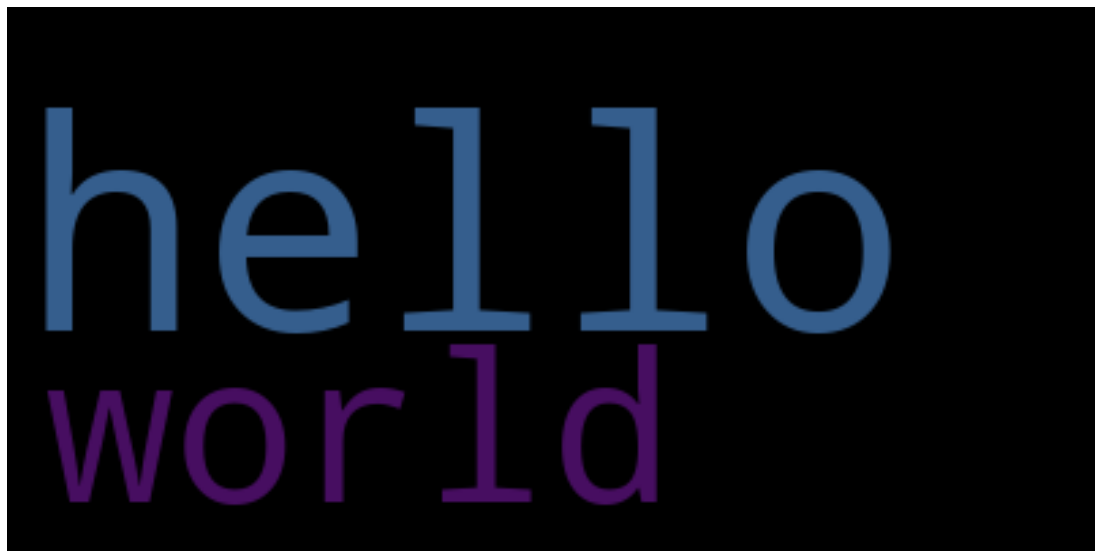

In [ ]:
# example
word_frequencies_1 = Counter({'hello':5,'world':2})
generateWordCloud(word_frequencies_1)

# France vs Argentina Live Tweets Analysis

We calculate word frequencies for the corpus overall.

In [ ]:
word_frequencies = generateCorpusWordFrequencies(versus_tokens)

We can see what the most common `n` words are in the corpus of washer reviews. 

In [ ]:
n = 3
word_frequencies.most_common(n)

[('de', 524), ('france', 520), ('la', 387)]

We can check to see how common a specific word is. 

In [ ]:
w = 'messi'
o = 'problemas'
print(word_frequencies[w])
print(word_frequencies[o])

25
1


We create a word cloud based on all washer reviews. 

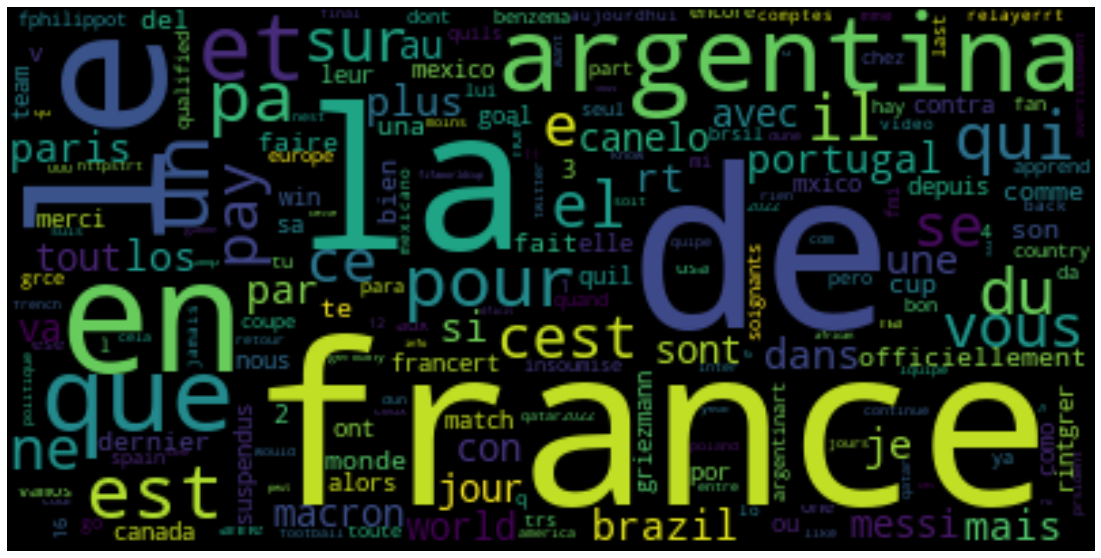

In [ ]:
generateWordCloud(word_frequencies)

We use `getCorpusSentimentCounts` to calculate the number of positive, negative, neutral, and total tweets for each party. 

In [ ]:
fra_corpus_counts = getCorpusSentimentCounts(fra_corpus)
arg_corpus_counts = getCorpusSentimentCounts(arg_corpus)

We calculate the following summary statistics:
* Number of Tweets
* Share of Voice
* Positive Percent
* Neutral Percent
* Negative Percent
* Net Positive Percent

In [ ]:
fra_corpus_summary = {
    'NTweets' : fra_corpus_counts['tot'],
    'ShareofVoice' : 100*fra_corpus_counts['tot']/(fra_corpus_counts['tot']+arg_corpus_counts['tot']),
    'PositivePct' : 100*fra_corpus_counts['pos']/fra_corpus_counts['tot'],
    'NeutralPct' : 100*fra_corpus_counts['neu']/fra_corpus_counts['tot'],
    'NegativePct' : 100*fra_corpus_counts['neg']/fra_corpus_counts['tot'],
    'NetPositivePct' : 100*(fra_corpus_counts['pos']-fra_corpus_counts['neg'])/fra_corpus_counts['tot']
}
arg_corpus_summary = {
    'NTweets' : arg_corpus_counts['tot'],
    'ShareofVoice' : 100*arg_corpus_counts['tot']/(fra_corpus_counts['tot']+arg_corpus_counts['tot']),
    'PositivePct' : 100*arg_corpus_counts['pos']/arg_corpus_counts['tot'],
    'NeutralPct' : 100*arg_corpus_counts['neu']/arg_corpus_counts['tot'],
    'NegativePct' : 100*arg_corpus_counts['neg']/arg_corpus_counts['tot'],
    'NetPositivePct' : 100*(arg_corpus_counts['pos']-arg_corpus_counts['neg'])/arg_corpus_counts['tot']
}

We display these summary statistics in a table. 

In [ ]:
print("")
print(' | '+
      'Teams          | '+
      '# Tweets       | '+
      'Share of Fan Voice | '+
      'Positive %     | '+
      'Neutral %      | '+
      'Negative %     | '+
      'Net Positive % | ')
print("")
print((" | "+
      "Argentina   | "+
      "{NTweets:5.0f}          | "+
      "{ShareofVoice:5.2f}%         | "+
      "{PositivePct:2.2f}%         | "+
      "{NeutralPct:2.2f}%         | "+
      "{NegativePct:2.2f}%         | "+
      "{NetPositivePct:2.2f}%         | ").format(**arg_corpus_summary))
print((" | "+
      "France      | "+
      "{NTweets:5.0f}          | "+
      "{ShareofVoice:5.2f}%         | "+
      "{PositivePct:2.2f}%         | "+
      "{NeutralPct:2.2f}%         | "+
      "{NegativePct:2.2f}%         | "+
      "{NetPositivePct:2.2f}%         | ").format(**fra_corpus_summary))
print("")


 | Teams          | # Tweets       | Share of Fan Voice | Positive %     | Neutral %      | Negative %     | Net Positive % | 

 | Argentina   |   196          | 27.45%         | 15.31%         | 73.98%         | 10.71%         | 4.59%         | 
 | France      |   518          | 72.55%         | 17.18%         | 60.04%         | 22.78%         | -5.60%         | 

